In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
from imblearn.over_sampling import SMOTE
from collections import Counter

np.random.seed(0)

# LOADING DATA

In [3]:
data = pd.read_csv("../input/weather-dataset-rattle-package/weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**About the data:**

The dataset contains about 10 years of daily weather observations from different locations across Australia. Observations were drawn from numerous weather stations. 

In this project, I will use this data to predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not. 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

**Points to notice:**

* There are missing values in the dataset
* Dataset includes numeric and categorical values 


# DATA VISUALIZATION AND CLEANING

**Steps involves in this section:**

* Count plot of target column 
* Correlation amongst numeric attributes
* Parse Dates into datetime
* Encoding days and months as continuous cyclic features


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

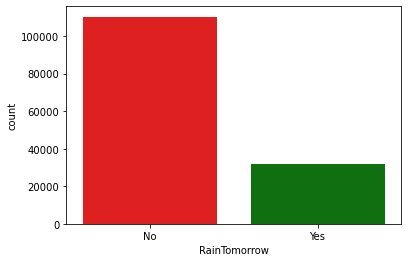

In [5]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols= ["red","green"]
sns.countplot(x= data["RainTomorrow"], palette= cols)

<AxesSubplot:>

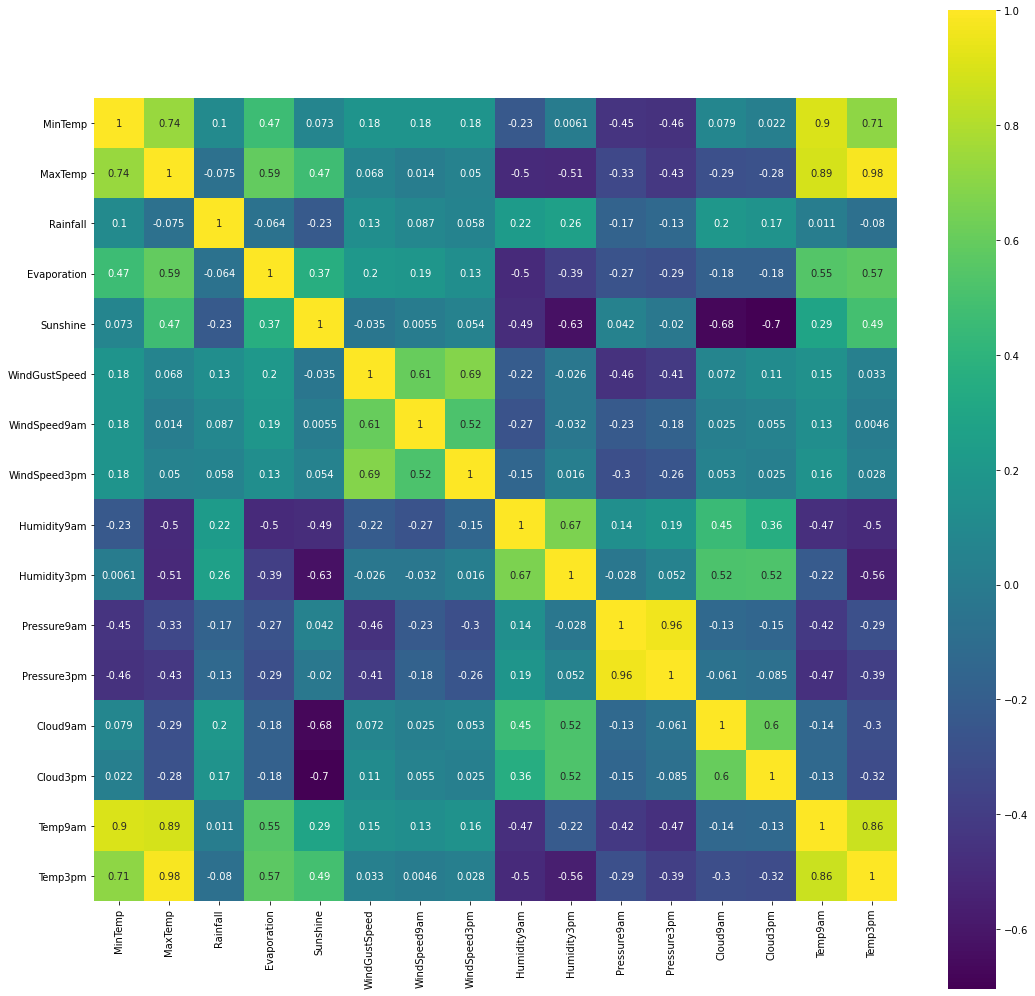

In [6]:
# Correlation amongst numeric attributes
corrmat = data.corr()
#cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
#sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)
sns.heatmap(corrmat,cmap='viridis',annot=True, square=True)

**Now I will parse Dates into datetime.**

My goal is to build an artificial neural network(ANN). I will encode dates appropriately, i.e. I prefer the months and days in a cyclic continuous feature. As, date and time are inherently cyclical. To let the ANN model know that a feature is cyclical I split it into periodic subsections. Namely, years, months and days. Now for each subsection, I create two new features, deriving a sine transform and cosine transform of the subsection feature. 

In [7]:
#Parsing datetime
#exploring the length of date objects
lengths = data["Date"].str.len()
lengths.value_counts()

10    145460
Name: Date, dtype: int64

In [8]:
#There don't seem to be any error in dates so parsing values into datetime
data['Date']= pd.to_datetime(data["Date"])
#Creating a collumn of year
data['year'] = data.Date.dt.year

# function to encode datetime into cyclic parameters. 
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature. 

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

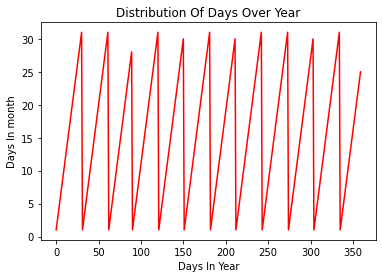

In [9]:
# roughly a year's span section 
section = data[:360] 
tm = section["day"].plot(color="red")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

As expected, the "year" attribute of data repeats. However in this for the true cyclic nature is not presented in a continuous manner. Splitting months and days into Sine and cosine combination provides the cyclical continuous feature. This can be used as input features to ANN. 

Text(0.5, 0, 'Sine Encoded Months')

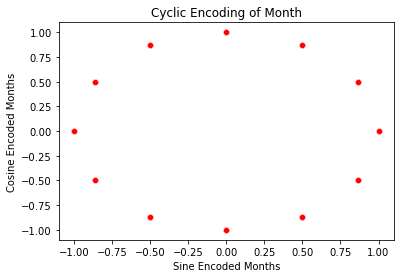

In [10]:
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="red")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")


Text(0.5, 0, 'Sine Encoded Day')

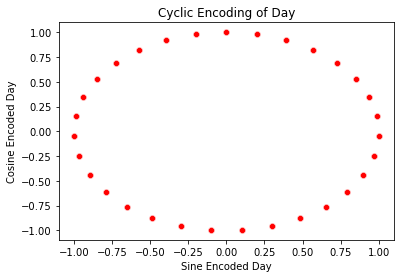

In [11]:
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="red")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

Next, I will deal with missing values in categorical and numeric attributes separately

**Categorical variables**

* Filling missing values with mode of the column value

In [12]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [13]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [14]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

**Numerical variables**

* Filling missing values with median of the column value

In [15]:
# Get list of numeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Numeric variables:")
print(num_cols)

Numeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [16]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [17]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True) #use the meadian because this one will not be as affected by outliers in a dataset as the mean
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

Text(0.5, 0, 'Years')

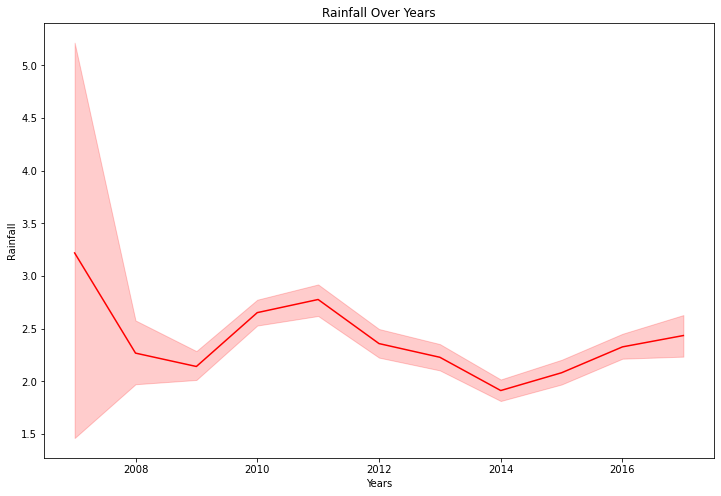

In [18]:
#plotting a lineplot rainfall over years
plt.figure(figsize=(12,8))
Time_series=sns.lineplot(x=data['Date'].dt.year,y="Rainfall",data=data,color="red")
Time_series.set_title("Rainfall Over Years")
Time_series.set_ylabel("Rainfall")
Time_series.set_xlabel("Years")

Text(0.5, 0, 'Year')

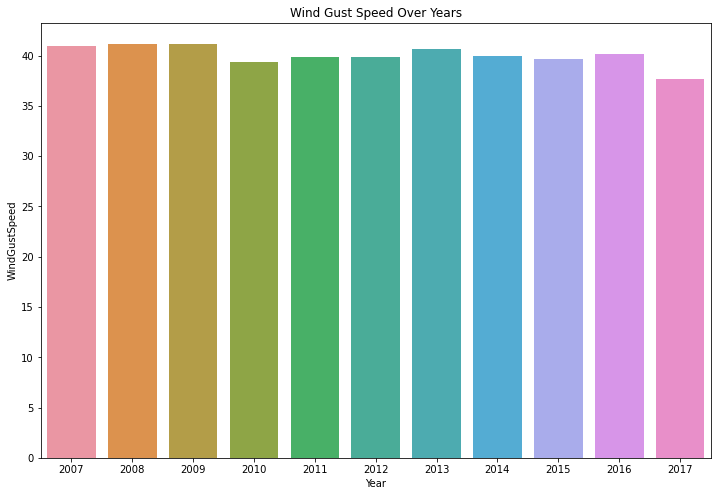

In [19]:
#Evauating Wind gust speed over years
#colours = ["red", "blue", "green", "yellow", "orange"]
plt.figure(figsize=(12,8))
Days_of_week=sns.barplot(x=data['Date'].dt.year,y="WindGustSpeed",data=data, ci =None)#,palette = colours)
Days_of_week.set_title("Wind Gust Speed Over Years")
Days_of_week.set_ylabel("WindGustSpeed")
Days_of_week.set_xlabel("Year")

In [20]:
data.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
year             0
month            0
month_sin        0
month_cos        0
day              0
day_sin          0
day_cos          0
dtype: int64


 
# DATA PREPROCESSING

**Steps involved in Data Preprocessing:**

* Label encoding columns with categorical data
* Perform the scaling of the features
* Detecting outliers
* Dropping the outliers based on data analysis

**Label encoding the catagorical varable**

In [21]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int64         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int64         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int64         
 10  WindDir3pm     145460 non-null  int64         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [22]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
#minmax_scaler = preprocessing.MinMaxScaler()
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,-5.633017e-14,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.243854e-15,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,6.513740e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,9.152711e-15,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,1.352327e-14,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-4.338304e-15,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,1.864381e-14,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,-1.167921e-14,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,-7.433272e-15,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,1.791486e-15,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


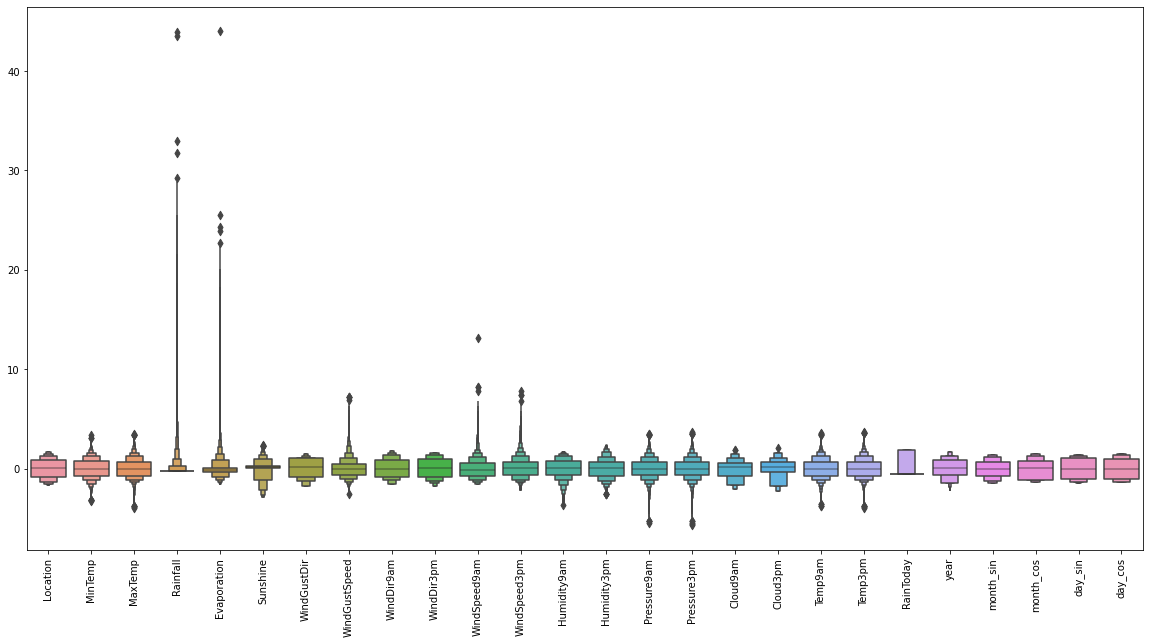

In [23]:
#Detecting outliers
#looking at the scaled features
#colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features)#,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [24]:
#full data for 
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 27)

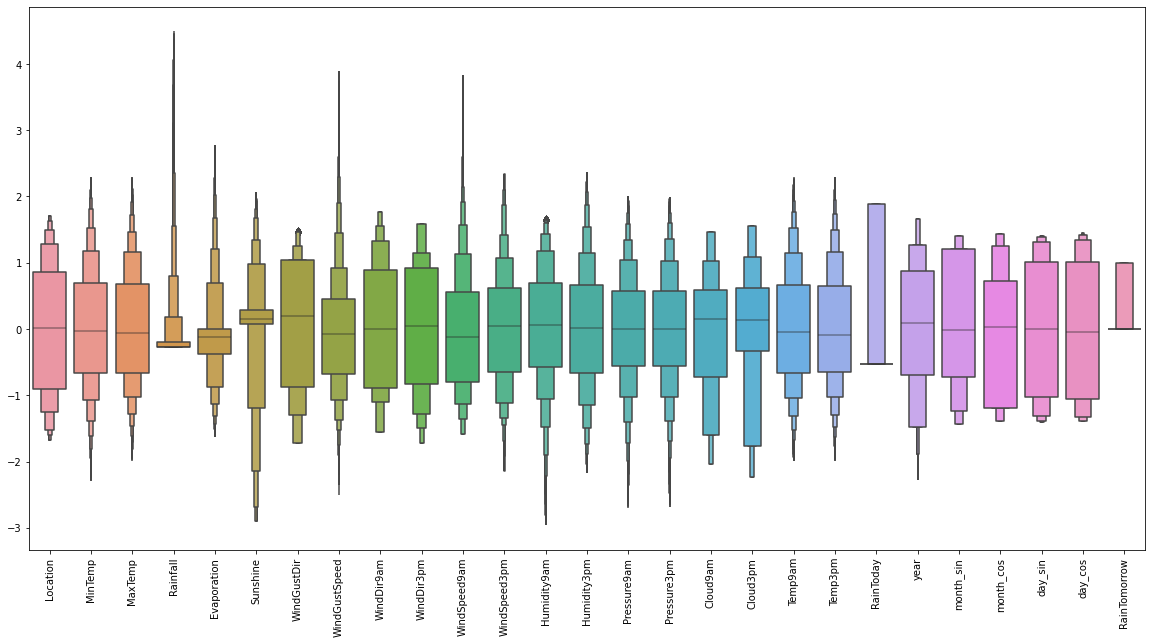

In [25]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features)#,palette = colours)
plt.xticks(rotation=90)
plt.show()

Looks Good. Up next is building artificial neural network.


# MODEL BUILDING


**In this project, we build an artificial neural network.**

**Following steps are involved in the model building**

* Assining X and y the status of attributes and tags
* Splitting test and training sets
* Initialising the neural network
* Defining by adding layers
* Compiling the neural network
* Train the neural network

In [26]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape

(127536, 26)

In [27]:
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos
0,-1.531666,0.189757,-0.044575,-0.203581,-0.119472,0.14871,1.045228,0.307739,1.328766,1.366458,...,1.464068,0.137693,-0.013506,0.019135,-0.529795,-1.879575,-0.016425,1.434192,0.278970,1.426023
1,-1.531666,-0.752786,0.265794,-0.275097,-0.119472,0.14871,1.258262,0.307739,-0.221338,1.586813,...,0.149133,0.137693,0.033011,0.384064,-0.529795,-1.879575,-0.016425,1.434192,0.549587,1.339551
2,-1.531666,0.111212,0.350440,-0.275097,-0.119472,0.14871,1.471296,0.460168,1.328766,1.586813,...,0.149133,-1.286294,0.622225,0.223495,-0.529795,-1.879575,-0.016425,1.434192,0.797572,1.199371
3,-1.531666,-0.470023,0.674917,-0.275097,-0.119472,0.14871,-0.872075,-1.216548,0.442992,-1.718521,...,0.149133,0.137693,0.172562,0.705202,-0.529795,-1.879575,-0.016425,1.434192,1.012774,1.011221
4,-1.531666,0.833828,1.281548,-0.155903,-0.119472,0.14871,1.045228,0.079096,-1.328556,-0.176032,...,1.025756,1.561680,0.126045,1.172312,-0.529795,-1.879575,-0.016425,1.434192,1.186382,0.782805


In [28]:
X.describe()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos
count,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,...,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000,127536.000000
mean,0.001978,0.025710,0.014992,-0.066608,-0.076740,0.001478,-0.000482,-0.062498,0.008537,-0.011114,...,0.003607,-0.003232,0.022508,0.015485,-0.012484,-0.004934,0.018024,0.009315,-0.003014,0.000302
std,0.996013,0.929286,0.891846,0.578187,0.705357,0.994395,1.001698,0.892263,1.000067,1.001079,...,0.994720,0.998393,0.900188,0.893503,0.991414,1.001174,1.009524,0.990199,0.999991,1.000031
min,-1.672228,-2.292273,-1.991436,-0.275097,-1.629472,-2.897217,-1.724209,-2.512192,-1.550000,-1.718521,...,-2.042425,-2.235619,-1.998224,-1.995277,-0.529795,-2.273637,-1.434333,-1.388032,-1.403140,-1.392587
25%,-0.899139,-0.658532,-0.665313,-0.275097,-0.371139,0.076188,-0.872075,-0.683048,-0.885669,-0.837098,...,-0.727490,-0.336969,-0.664741,-0.652336,-0.529795,-0.697391,-0.725379,-1.198979,-1.019170,-1.055520
50%,0.014511,-0.030170,-0.058683,-0.275097,-0.119472,0.148710,0.193094,-0.073333,0.000105,0.044324,...,0.149133,0.137693,-0.044517,-0.083046,-0.529795,0.090732,-0.016425,0.023080,-0.003198,-0.044639
75%,0.857881,0.692446,0.674917,-0.203581,0.006361,0.293755,1.045228,0.460168,0.885879,0.925747,...,0.587445,0.612356,0.668741,0.646814,-0.529795,0.878855,1.211519,0.728636,1.012774,1.011221
max,1.701250,2.294769,2.297301,4.492630,2.774694,2.070546,1.471296,3.889814,1.771653,1.586813,...,1.464068,1.561680,2.296831,2.296296,1.887521,1.666978,1.401483,1.434192,1.396744,1.455246


balance the dataset

In [29]:
#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
2551/2551 [==============================] - 6s 2ms/step - loss: 0.5545 - accuracy: 0.7813 - val_loss: 0.3907 - val_accuracy: 0.7860
Epoch 2/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.4131 - accuracy: 0.8017 - val_loss: 0.3824 - val_accuracy: 0.8403
Epoch 3/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.4078 - accuracy: 0.8117 - val_loss: 0.3768 - val_accuracy: 0.8414
Epoch 4/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.4009 - accuracy: 0.8148 - val_loss: 0.3728 - val_accuracy: 0.8427
Epoch 5/150
2551/2551 [==============================] - 4s 2ms/step - loss: 0.3961 - accuracy: 0.8154 - val_loss: 0.3706 - val_accuracy: 0.8430
Epoch 6/150
2551/2551 [==============================] - 5s 2ms/step - loss: 0.3953 - accuracy: 0.8154 - val_loss: 0.3687 - val_accuracy: 0.8439
Epoch 7/150
2551/2551 [==============================] - 5s 2ms/step - loss: 0.3954 - accuracy: 0.8157 - val_loss: 0.3680 - val_ac

Plotting training and validation loss over epochs

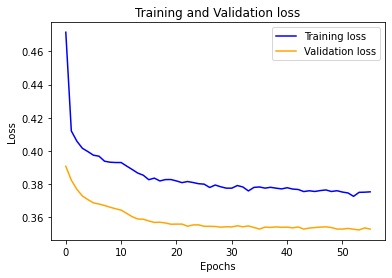

In [30]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "blue", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"orange", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

Plotting training and validation accuracy over epochs

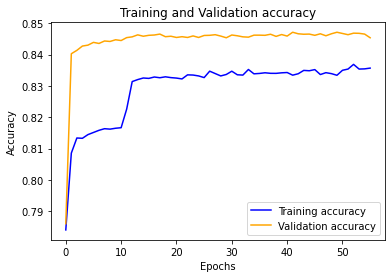

In [31]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "blue", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "orange", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

so we experience underfitting, this means we have to make the model more complex to gather all the features in multiple dimensions


# CONCLUSIONS


**Concluding the model with:**

* Testing on the test set
* Evaluating the confusion matrix
* Evaluating the classification report

In [32]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

Text(0, 0.5, 'Count')

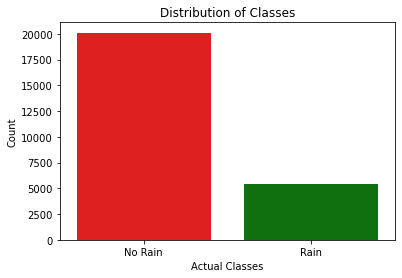

In [33]:
class_labels = ['No Rain', 'Rain']
cols = ["red", "green"]

# Create a countplot
sns.countplot(x=y_test, palette=cols)

# Set x-axis labels using class labels
plt.xticks(ticks=[0, 1], labels=class_labels)

# Set plot title and labels
plt.title('Distribution of Classes')
plt.xlabel('Actual Classes')
plt.ylabel('Count')

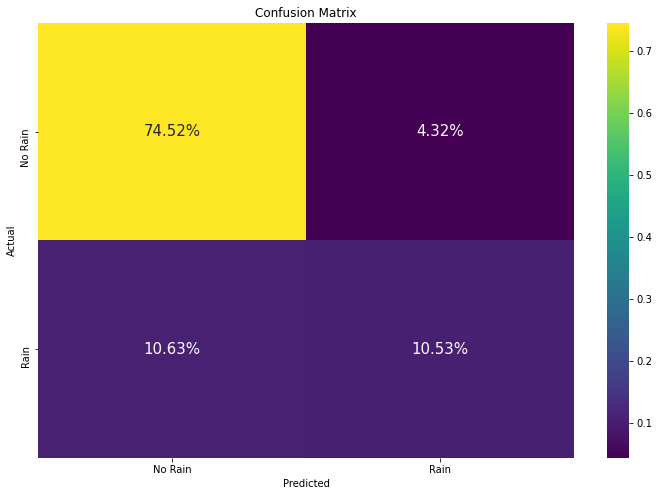

In [34]:
cf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['No Rain', 'Rain']

# Plot the heatmap
plt.subplots(figsize=(12, 8))
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap='viridis', annot=True, fmt='.2%', annot_kws={'size': 15},
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

## Addtion

so the results do look promising at the first glance but through the confusion matrix we can see that the no rain examples are way oversampled, so the prediction for actual Rain data is poor and way undersampled in the test data 
for this the SMOTE approach could be used on the data to imporve the quality of the results


In [ ]:
print(classification_report(y_test, y_pred))

## Improvements

the follwing approaches are tested:

1. scale with standard scaler then used SMOTE
2. scale with minmax scaler
3. after all of the above are tested with the 'smaller' network, try to adapt the network to a larger one

In [19]:
def preprocessing_dataset(data):
    #There don't seem to be any error in dates so parsing values into datetime
    data['Date']= pd.to_datetime(data["Date"])
    #Creating a collumn of year
    data['year'] = data.Date.dt.year

    # function to encode datetime into cyclic parameters. 
    #As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature. 

    def encode(data, col, max_val):
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data

    data['month'] = data.Date.dt.month
    data = encode(data, 'month', 12)

    data['day'] = data.Date.dt.day
    data = encode(data, 'day', 31)

    # Get list of categorical variables
    s = (data.dtypes == "object")
    object_cols = list(s[s].index)

   
    # Filling missing values with mode of the column in value

    for i in object_cols:
        data[i].fillna(data[i].mode()[0], inplace=True)
        
    # Get list of numeric variables
    t = (data.dtypes == "float64")
    num_cols = list(t[t].index)

    # Filling missing values with median of the column in value

    for i in num_cols:
        data[i].fillna(data[i].median(), inplace=True) #use the meadian because this one will not be as affected by outliers in a dataset as the mean

    
    # Apply label encoder to each column with categorical data
    label_encoder = LabelEncoder()
    for i in object_cols:
        data[i] = label_encoder.fit_transform(data[i])

    # Prepairing attributes of scale data

    features = data.drop(['RainTomorrow', 'Date','day', 'month'], axis=1) # dropping target and extra columns

    target = data['RainTomorrow']

    #Set up a standard scaler for the features
    col_names = list(features.columns)
    s_scaler = MinMaxScaler()
    #s_scaler = StandardScaler()
    features = s_scaler.fit_transform(features)
    features = pd.DataFrame(features, columns=col_names) 

    #full data for 
    features["RainTomorrow"] = target

    #Dropping with outlier

    features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
    features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
    features = features[(features["Rainfall"]<4.5)]
    features = features[(features["Evaporation"]<2.8)]
    features = features[(features["Sunshine"]<2.1)]
    features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
    features = features[(features["WindSpeed9am"]<4)]
    features = features[(features["WindSpeed3pm"]<2.5)]
    features = features[(features["Humidity9am"]>-3)]
    features = features[(features["Humidity3pm"]>-2.2)]
    features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
    features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
    features = features[(features["Cloud9am"]<1.8)]
    features = features[(features["Cloud3pm"]<2)]
    features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
    features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]
    
    
    X = features.drop(["RainTomorrow"], axis=1)
    y = features["RainTomorrow"]

    # Splitting test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    
    return X_train,X_test,y_train,y_test

In [8]:
def get_predictions(model, X_test):
    # Predicting the test set results
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)
    return y_pred

def show_distribution(y_test):
    class_labels = ['No Rain', 'Rain']
    cols = ["red", "green"]

    # Create a countplot
    sns.countplot(x=y_test, palette=cols)

    # Set x-axis labels using class labels
    plt.xticks(ticks=[0, 1], labels=class_labels)

    # Set plot title and labels
    plt.title('Distribution of Classes')
    plt.xlabel('Actual Classes')
    plt.ylabel('Count')
    plt.show()
    
    
def show_matrix(y_test,y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Define class labels
    class_labels = ['No Rain', 'Rain']

    # Plot the heatmap
    plt.subplots(figsize=(12, 8))
    sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap='viridis', annot=True, fmt='.2%', annot_kws={'size': 15},
                xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.show()

In [ ]:
#cols = X_train.columns
#print(cols)
#scaler = StandardScaler()

#X_train = scaler.fit_transform(X_train)

#X_test = scaler.transform(X_test)

#X_train = pd.DataFrame(X_train, columns=[cols])

#X_test = pd.DataFrame(X_test, columns=[cols])

In [40]:
data = pd.read_csv("../input/weather-dataset-rattle-package/weatherAUS.csv")
X_train,X_test,y_train,y_test = preprocessing_dataset(data)

os = SMOTE()
X_train, y_train = os.fit_resample(X_train, y_train)
count = Counter(y_train)
print(count)

Counter({1: 80047, 0: 80047})


In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.001,  # minimum amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    factor=0.2,  # factor by which the learning rate will be reduced
    patience=10,  # number of epochs with no improvement after which learning rate will be reduced
    min_delta=0.0,  # threshold for measuring the new optimum
    verbose=1,  # verbosity mode
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
4003/4003 [==============================] - 8s 2ms/step - loss: 0.5905 - accuracy: 0.6786 - val_loss: 0.6842 - val_accuracy: 0.6700
Epoch 2/150
4003/4003 [==============================] - 7s 2ms/step - loss: 0.4896 - accuracy: 0.7815 - val_loss: 0.6527 - val_accuracy: 0.6607
Epoch 3/150
4003/4003 [==============================] - 7s 2ms/step - loss: 0.4866 - accuracy: 0.7837 - val_loss: 0.6576 - val_accuracy: 0.6601
Epoch 4/150
4003/4003 [==============================] - 7s 2ms/step - loss: 0.4833 - accuracy: 0.7853 - val_loss: 0.6537 - val_accuracy: 0.6586
Epoch 5/150
4003/4003 [==============================] - 7s 2ms/step - loss: 0.4799 - accuracy: 0.7864 - val_loss: 0.6301 - val_accuracy: 0.6593
Epoch 6/150
4003/4003 [==============================] - 7s 2ms/step - loss: 0.4740 - accuracy: 0.7905 - val_loss: 0.6245 - val_accuracy: 0.6650
Epoch 7/150
4003/4003 [==============================] - 7s 2ms/step - loss: 0.4720 - accuracy: 0.7904 - val_loss: 0.6223 - val_ac

In [44]:
y_pred = get_predictions(model, X_test)

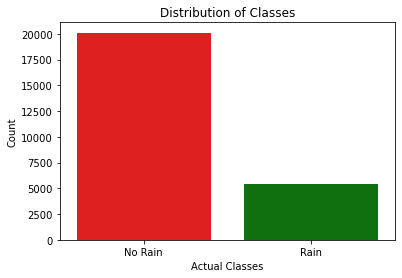

In [45]:
show_distribution(y_test)

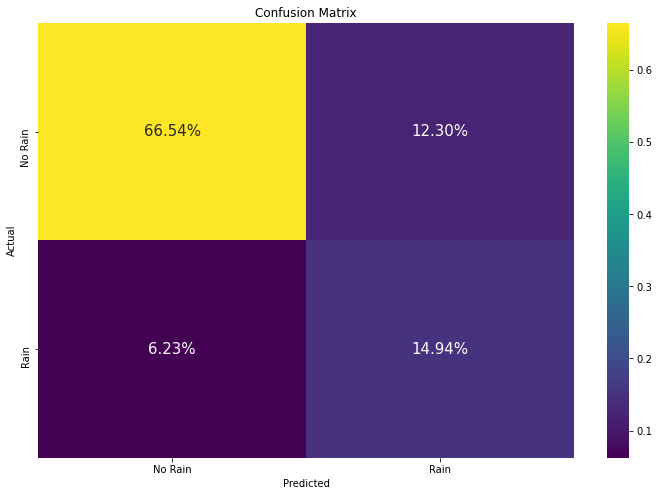

In [46]:
show_matrix(y_test,y_pred)

In [48]:
data = pd.read_csv("../input/weather-dataset-rattle-package/weatherAUS.csv")
X_train,X_test,y_train,y_test = preprocessing_dataset(data)

os = SMOTE()
X_train, y_train = os.fit_resample(X_train, y_train)
count = Counter(y_train)
print(count)

Counter({1: 90911, 0: 90911})


In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.001,  # minimum amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    factor=0.2,  # factor by which the learning rate will be reduced
    patience=10,  # number of epochs with no improvement after which learning rate will be reduced
    min_delta=0.0,  # threshold for measuring the new optimum
    verbose=1,  # verbosity mode
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
4546/4546 [==============================] - 9s 2ms/step - loss: 0.6354 - accuracy: 0.6448 - val_loss: 0.8185 - val_accuracy: 0.6472
Epoch 2/150
4546/4546 [==============================] - 8s 2ms/step - loss: 0.5216 - accuracy: 0.7635 - val_loss: 0.7709 - val_accuracy: 0.6670
Epoch 3/150
4546/4546 [==============================] - 8s 2ms/step - loss: 0.5064 - accuracy: 0.7735 - val_loss: 0.7173 - val_accuracy: 0.6766
Epoch 4/150
4546/4546 [==============================] - 8s 2ms/step - loss: 0.5021 - accuracy: 0.7749 - val_loss: 0.7050 - val_accuracy: 0.6820
Epoch 5/150
4546/4546 [==============================] - 8s 2ms/step - loss: 0.4969 - accuracy: 0.7757 - val_loss: 0.6857 - val_accuracy: 0.6853
Epoch 6/150
4546/4546 [==============================] - 8s 2ms/step - loss: 0.4926 - accuracy: 0.7772 - val_loss: 0.6444 - val_accuracy: 0.7093
Epoch 7/150
4546/4546 [==============================] - 8s 2ms/step - loss: 0.4930 - accuracy: 0.7765 - val_loss: 0.6805 - val_ac

In [50]:
y_pred = get_predictions(model, X_test)

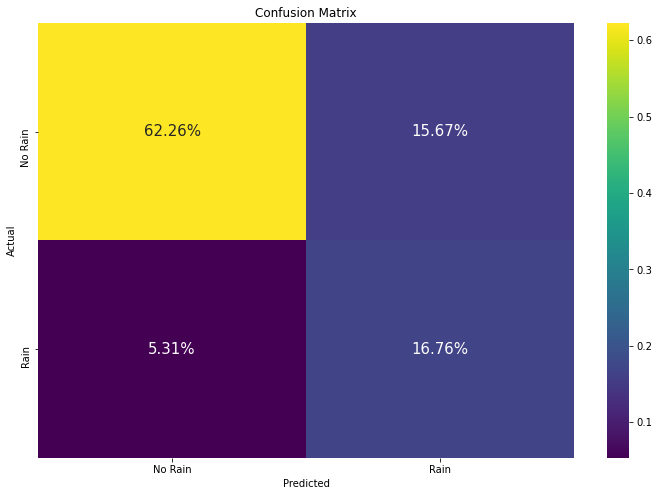

In [51]:
show_matrix(y_test,y_pred)

In [9]:
data = pd.read_csv("../input/weather-dataset-rattle-package/weatherAUS.csv")
X_train,X_test,y_train,y_test = preprocessing_dataset(data)

os = SMOTE()
X_train, y_train = os.fit_resample(X_train, y_train)
count = Counter(y_train)
print(count)

Counter({1: 80047, 0: 80047})


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.001,  # minimum amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    factor=0.3,  # factor by which the learning rate will be reduced
    patience=5,  # number of epochs with no improvement after which learning rate will be reduced
    min_delta=0.0,  # threshold for measuring the new optimum
    verbose=1,  # verbosity mode
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping,reduce_lr], validation_split=0.2)

Epoch 1/150
4003/4003 [==============================] - 18s 4ms/step - loss: 0.5818 - accuracy: 0.7381 - val_loss: 0.5635 - val_accuracy: 0.6575
Epoch 2/150
4003/4003 [==============================] - 17s 4ms/step - loss: 0.5091 - accuracy: 0.7780 - val_loss: 0.6345 - val_accuracy: 0.6396
Epoch 3/150
4003/4003 [==============================] - 16s 4ms/step - loss: 0.4991 - accuracy: 0.7805 - val_loss: 0.5273 - val_accuracy: 0.7081
Epoch 4/150
4003/4003 [==============================] - 16s 4ms/step - loss: 0.4952 - accuracy: 0.7779 - val_loss: 0.5863 - val_accuracy: 0.6733
Epoch 5/150
4003/4003 [==============================] - 17s 4ms/step - loss: 0.4894 - accuracy: 0.7763 - val_loss: 0.5283 - val_accuracy: 0.6708
Epoch 6/150
4003/4003 [==============================] - 16s 4ms/step - loss: 0.4823 - accuracy: 0.7779 - val_loss: 0.6088 - val_accuracy: 0.6376
Epoch 7/150
4003/4003 [==============================] - 16s 4ms/step - loss: 0.4778 - accuracy: 0.7815 - val_loss: 0.6613 -

In [11]:
y_pred = get_predictions(model, X_test)

this results are so far the best by using the standard scaler + SMOTE and the larger ANN

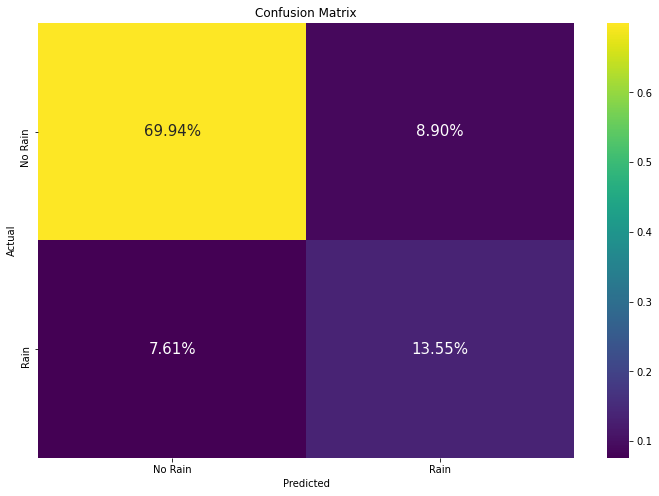

In [12]:
show_matrix(y_test,y_pred)

So with the SMOTE balanced dataset the model does work better on the Rain prediction, but now lacks on the prediction of the differentiation of the rain and no rain prediction

In [17]:
y_test_array = np.array(y_test)

# Count occurrences of each class
class_counts = np.bincount(y_test_array)
all_data = len(y_test_array)

# Display the counts
for class_label, count in enumerate(class_counts):
    print(f'Class {class_label}: {count} occurrences, which is equal to {round((count/all_data)*100,2)}%')

Class 0: 20110 occurrences, which is equal to 78.84%
Class 1: 5398 occurrences, which is equal to 21.16%


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     20110
           1       0.60      0.64      0.62      5398

    accuracy                           0.83     25508
   macro avg       0.75      0.76      0.76     25508
weighted avg       0.84      0.83      0.84     25508



In [20]:
data = pd.read_csv("../input/weather-dataset-rattle-package/weatherAUS.csv")
X_train,X_test,y_train,y_test = preprocessing_dataset(data)

os = SMOTE()
X_train, y_train = os.fit_resample(X_train, y_train)
count = Counter(y_train)
print(count)

Counter({1: 90911, 0: 90911})


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.001,  # minimum amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    factor=0.3,  # factor by which the learning rate will be reduced
    patience=5,  # number of epochs with no improvement after which learning rate will be reduced
    min_delta=0.0,  # threshold for measuring the new optimum
    verbose=1,  # verbosity mode
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping,reduce_lr], validation_split=0.2)

Epoch 1/150
4546/4546 [==============================] - 19s 4ms/step - loss: 0.5634 - accuracy: 0.6932 - val_loss: 0.7775 - val_accuracy: 0.5942
Epoch 2/150
4546/4546 [==============================] - 18s 4ms/step - loss: 0.5033 - accuracy: 0.7831 - val_loss: 0.6940 - val_accuracy: 0.6467
Epoch 3/150
4546/4546 [==============================] - 19s 4ms/step - loss: 0.4925 - accuracy: 0.7869 - val_loss: 0.6714 - val_accuracy: 0.6525
Epoch 4/150
4546/4546 [==============================] - 18s 4ms/step - loss: 0.4884 - accuracy: 0.7860 - val_loss: 1.0344 - val_accuracy: 0.4336
Epoch 5/150
4546/4546 [==============================] - 18s 4ms/step - loss: 0.4835 - accuracy: 0.7867 - val_loss: 0.6552 - val_accuracy: 0.7120
Epoch 6/150
4546/4546 [==============================] - 18s 4ms/step - loss: 0.4847 - accuracy: 0.7868 - val_loss: 0.4558 - val_accuracy: 0.8386
Epoch 7/150
4546/4546 [==============================] - 19s 4ms/step - loss: 0.4809 - accuracy: 0.7891 - val_loss: 0.6517 -

In [30]:
y_pred = get_predictions(model, X_test)

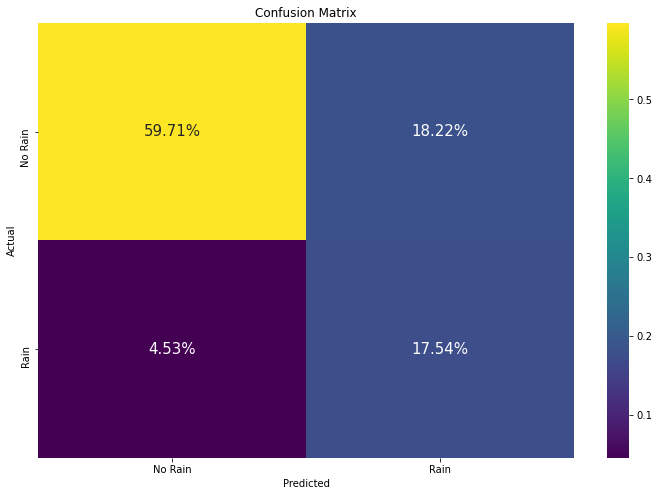

In [31]:
show_matrix(y_test,y_pred)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84     22672
           1       0.49      0.79      0.61      6420

    accuracy                           0.77     29092
   macro avg       0.71      0.78      0.72     29092
weighted avg       0.83      0.77      0.79     29092



In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.001,  # minimum amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    factor=0.3,  # factor by which the learning rate will be reduced
    patience=5,  # number of epochs with no improvement after which learning rate will be reduced
    min_delta=0.0,  # threshold for measuring the new optimum
    verbose=1,  # verbosity mode
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, activation = 'relu', input_dim = 26))
model.add(Dropout(0.2))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping,reduce_lr], validation_split=0.2)

Epoch 1/150
4546/4546 [==============================] - 7s 1ms/step - loss: 0.6481 - accuracy: 0.6276 - val_loss: 0.8229 - val_accuracy: 0.5846
Epoch 2/150
4546/4546 [==============================] - 7s 1ms/step - loss: 0.5642 - accuracy: 0.7028 - val_loss: 0.6999 - val_accuracy: 0.6998
Epoch 3/150
4546/4546 [==============================] - 6s 1ms/step - loss: 0.5308 - accuracy: 0.7233 - val_loss: 0.6753 - val_accuracy: 0.6992
Epoch 4/150
4546/4546 [==============================] - 7s 1ms/step - loss: 0.5191 - accuracy: 0.7292 - val_loss: 0.6475 - val_accuracy: 0.7072
Epoch 5/150
4546/4546 [==============================] - 7s 1ms/step - loss: 0.5098 - accuracy: 0.7367 - val_loss: 0.6511 - val_accuracy: 0.6898
Epoch 6/150
4546/4546 [==============================] - 7s 1ms/step - loss: 0.5042 - accuracy: 0.7561 - val_loss: 0.6530 - val_accuracy: 0.6817
Epoch 7/150
4546/4546 [==============================] - 7s 1ms/step - loss: 0.5013 - accuracy: 0.7700 - val_loss: 0.6575 - val_ac

In [34]:
y_pred = get_predictions(model, X_test)

less layers: 32, 32, 16, 8, 1 with kernel init uniform and two dropouts with 50% at the last two layer

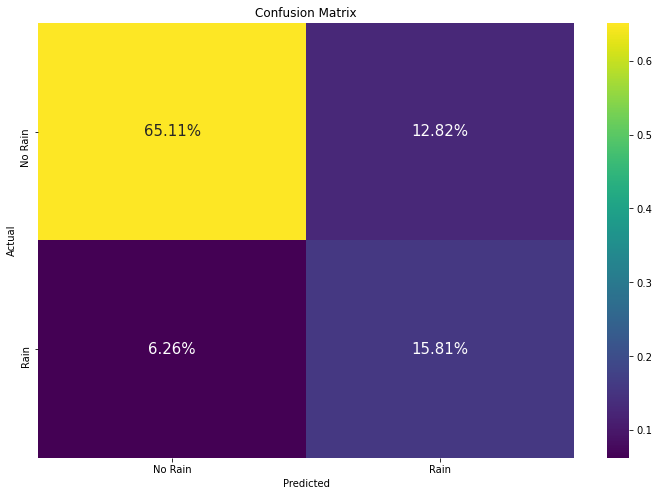

In [35]:
show_matrix(y_test,y_pred)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87     22672
           1       0.55      0.72      0.62      6420

    accuracy                           0.81     29092
   macro avg       0.73      0.78      0.75     29092
weighted avg       0.83      0.81      0.82     29092



In [40]:
y_pred = get_predictions(model, X_test)

even fewer layers with: 32,16,8,1 with kernel init uniform and two dropouts with 50% at the last two layer

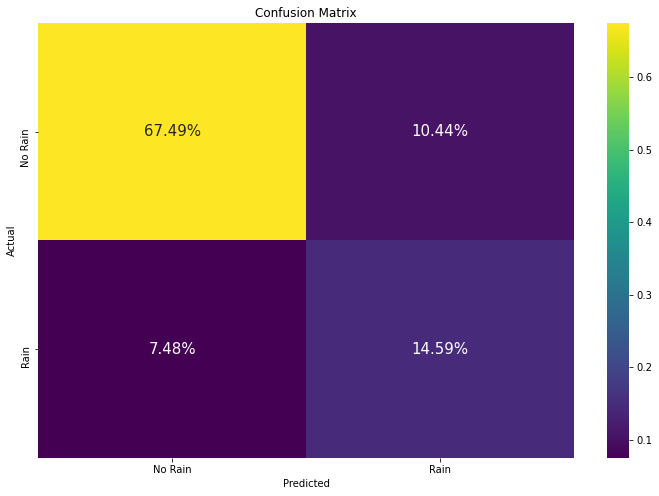

In [41]:
show_matrix(y_test,y_pred)

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     22672
           1       0.58      0.66      0.62      6420

    accuracy                           0.82     29092
   macro avg       0.74      0.76      0.75     29092
weighted avg       0.83      0.82      0.82     29092



In [47]:
y_pred = get_predictions(model, X_test)

even fewer layers with: 32,16,8,1 without kernel init uniform and three dropouts with 20%, 25% and 50% at all layers

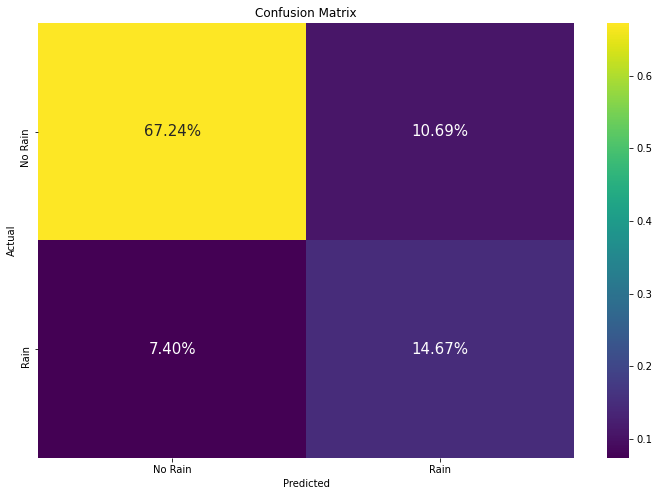

In [48]:
show_matrix(y_test,y_pred)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88     22672
           1       0.58      0.66      0.62      6420

    accuracy                           0.82     29092
   macro avg       0.74      0.76      0.75     29092
weighted avg       0.83      0.82      0.82     29092

